<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Reservoir-Sampling" data-toc-modified-id="Reservoir-Sampling-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Reservoir Sampling</a></span></li><li><span><a href="#Features-(TBD)" data-toc-modified-id="Features-(TBD)-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Features (TBD)</a></span></li></ul></div>

# Reservoir Sampling

Reservoir sampling is a statistical mechanism that helps gather a respresentative group of samples in buffer from a stream in an efficient way. Normally, it is used with adaptive probability so that samples from the whole stream can be captured in the buffer, so that a sketch of the whole stream can be drawn with integrity. An example is shown below, when the buffer size is _1_, only _1_ sample can be stored. When the first sample arrives, we store it with probability $p=1$. When the second sample arrives, we store it with probability $p=\frac{1}{2}$, and so on and so forth for the following samples. The goal is to make all elements have equal proability to be stored in the buffer.
![Adaptive Probability](https://florian.github.io/assets/posts/reservoir-sampling/adapting-probabilities.png)

However, in our load balancing problem which is dynamic and time-variant, what is more important is the more recent samples, instead of the whole stream. Therefore, it is more favorable to take a constant probability to store a newly arrived sample into the buffer so as to have an exponential distribution of "keep_probability" for each bin in the buffer.

Imagine we have a Poisson traffic stream with $\lambda$ as traffic rate. Denote $p$ as the probability of keeping a newly arrived element in the buffer (if the bin is already taken, then replace the previous sample stored in the bin). The size of buffer (total number of bins) is $k$. Then the expectation of number of events preserved in buffer after $n$ time intervals:

$E = \lambda p \left(\frac{k - p}{k}\right)^{\lambda n}$.

To give a clearer demonstration, we run the following simulation.

In [14]:
import math
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt

def nextTime(rateParameter):
    return -math.log(1.0 - random.random()) / rateParameter

def gen_poisson_traffic(query_rate=1., rate_base=40, dummy_n=100000, n_queries=80000, t_len=None, dummy_n_list=None, verbose=False):
    query_rate = rate_base * query_rate
    t_query = []
    url_query = []
    _t = 0.1
    cnt = 0
    if dummy_n_list is not None:
        for _, i in enumerate(dummy_n_list):
            _t += nextTime(query_rate)
            t_query.append(_t)
            url_query.append('/dummy.php/?n={}'.format(i))
            if _ % 1e5 == 0 and verbose:
                print("{}/{} - {:.2%}".format(_+1, len(dummy_n_list), (_+1)/len(dummy_n_list)))
        print("ETA: {}".format(_t))
    elif t_len is not None:
        while _t < t_len:
            _t += nextTime(query_rate)
            t_query.append(_t)
            url_query.append('/dummy.php/?n={}'.format(int(np.random.exponential(dummy_n))))
            cnt += 1
            if int(cnt) % 1e5 == 0 and verbose:
                print("{}/{} - {:.2%}".format(int(_t), int(t_len), int(_t)/int(t_len)))
        print("Number of queries: {}".format(cnt))
    else:
        while cnt < n_queries:
            _t += nextTime(query_rate)
            t_query.append(_t)
            url_query.append('/dummy.php/?n={}'.format(int(np.random.exponential(dummy_n))))
            cnt += 1
            if cnt % 1e5 == 0 and verbose:
                print("{}/{} - {:.2%}".format(cnt, n_queries, cnt/n_queries))
        print("ETA: {}".format(_t))
    
    df = pd.DataFrame(t_query, columns=['time'])
    df['query'] = url_query
    return df

In [ ]:
_lambda = 80 # event rate
_p = 0.05 # keep prob
_k = int(1e4) # buffer size
_n = int(1e5) # number of time intervals
df = gen_poisson_traffic(rate_base=_lambda, t_len=_n)

In [7]:
df.head()

,time,query
0,0.121088,/dummy.php/?n=185748
1,0.128092,/dummy.php/?n=315550
2,0.134400,/dummy.php/?n=33150
3,0.137571,/dummy.php/?n=19851
4,0.156077,/dummy.php/?n=57029


In [8]:
def reservoir(df, keep_prob, buffer_size, verbose=False, use_int=False, int_range=65536):
    if verbose:
        start = time.time()
    df = df.reset_index(drop=True) # in case we have messy index column in df
    arr = list(range(buffer_size)) # buffer of indexes
    N = len(df) # total amount of sequences
    if use_int: # the case in VPP
        thres = int(keep_prob * int_range)

    for i in range(buffer_size, N):
        if use_int:
            r = random.randint(0, int_range)
            if r < thres:
                arr[r%buffer_size] = i        
        else:
            r = random.uniform(0, 1)
            if r < keep_prob:
                arr[random.randint(0, buffer_size-1)] = i
        if i % int(1e5) == 0 and verbose:
            print("{}/{} - {:.3%}".format(i+1, N, (i+1)/N), end='\r')
    if verbose:
        print("\n>> time {:.3f}s".format(time.time() - start))
    return df.iloc[arr].reset_index(drop=True)

In [9]:
# generate reservoir samples
df_reservoir = reservoir(df, _p, int(_k))

In [11]:
bin_step = 10
bins = np.linspace(0, _n, int(_n/bin_step)) # create a set of bins to store samples in a given time interval
ss = np.searchsorted(bins, df_reservoir.time.values) # sort according to their timestamps

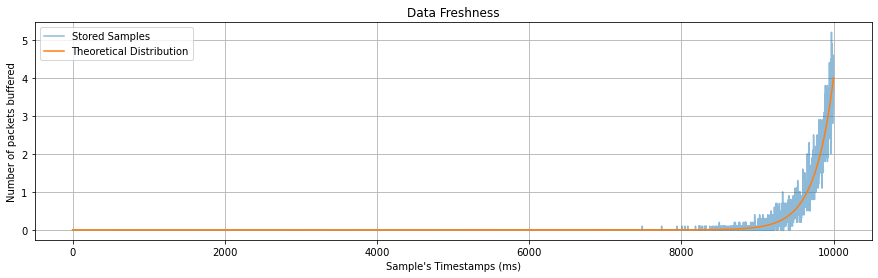

In [17]:
plt.figure(figsize=(15, 4))
bc = np.bincount(ss)[1:]/bin_step
plt.plot(bc, label='Stored Samples', alpha=0.5)
# fit curve
def fit_func(x, a, b, c):
    return a*b*np.power(c, a*x)

# params = curve_fit(fit_func, np.linspace(0, 1, _n), bc, p0=(_lambda, _p, (_k - _p)/_k))
# a, b, c = params[0]
# plt.plot([fit_func(i, a, b, c) for i in range(98000, _n)], label='fit')

arr = np.array([_lambda * _p * np.power((_k - _p)/_k, _lambda * (_n-i)) for i in bins])
plt.plot(arr, label='Theoretical Distribution')
plt.xlabel("Sample's Timestamps (ms)")
plt.ylabel("Number of packets buffered")
plt.title("Data Freshness")
plt.legend()
plt.grid()
plt.show()

As is shown above, this method helps us gather more recent observations, based on which features that reflect latest states can be generated.